# Ablation study

The authors propose augmenting the FEBRL training data with error statistics derived from ePBRN dataset (which is representative of real world medical records). The authors claim that augmenting the training data will provide a richer training set. We investigate how much impact said error-augmented data has on final model performance.

## Setup + imports

In [1]:
import recordlinkage as rl, pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from recordlinkage.preprocessing import phonetic
from numpy.random import choice
import collections, numpy
from IPython.display import clear_output
from sklearn.model_selection import train_test_split, KFold

In [2]:
from utils import (
    generate_true_links,
    generate_false_links,
    swap_fields_flag,
    join_names_space,
    join_names_dash,
    abb_surname,
    reset_day,
    set_random_seed
)
from training_utils import train_model, classify, evaluation, blocking_performance

In [3]:
set_random_seed()

In [4]:
trainset = 'ePBRN_dup_train' 
testset = 'ePBRN_dup_test'

In [5]:
def extract_features(df, links):
    c = rl.Compare()
    c.string('given_name', 'given_name', method='levenshtein', label='y_name_leven')
    c.string('surname', 'surname', method='levenshtein', label='y_surname_leven')  
    c.string('given_name', 'given_name', method='jarowinkler', label='y_name_jaro')
    c.string('surname', 'surname', method='jarowinkler', label='y_surname_jaro')  
    c.string('postcode', 'postcode', method='jarowinkler', label='y_postcode')      
    exact_fields = ['postcode', 'address_1', 'address_2', 'street_number']
    for field in exact_fields:
        c.exact(field, field, label='y_'+field+'_exact')
    c.compare_vectorized(reset_day,('day', 'month'), ('day', 'month'),label='reset_day_flag')    
    c.compare_vectorized(swap_fields_flag,('day', 'month'), ('day', 'month'),label='swap_day_month')    
    c.compare_vectorized(swap_fields_flag,('surname', 'given_name'), ('surname', 'given_name'),label='swap_names')    
    c.compare_vectorized(join_names_space,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_space')
    c.compare_vectorized(join_names_dash,('surname', 'given_name'), ('surname', 'given_name'),label='join_names_dash')
    c.compare_vectorized(abb_surname,'surname', 'surname',label='abb_surname')
    # Build features
    feature_vectors = c.compute(links, df, df)
    return feature_vectors

def generate_train_X_y(df,train_true_links):
    # This routine is to generate the feature vector X and the corresponding labels y
    # with exactly equal number of samples for both classes to train the classifier.
    pos = extract_features(df, train_true_links)
    train_false_links = generate_false_links(df, len(train_true_links))    
    neg = extract_features(df, train_false_links)
    X = pos.values.tolist() + neg.values.tolist()
    y = [1]*len(pos)+[0]*len(neg)
    X, y = shuffle(X, y, random_state=0)
    X = np.array(X)
    y = np.array(y)
    return X, y


## Training set construction

In [6]:
def _GetXTrain_YTrain(frac):
    df_train = pd.read_csv(trainset+".csv", index_col = "rec_id")
    match_ids = set(df_train['match_id'])
    for id_ in match_ids:
        filtered_df = df_train[df_train['match_id'] == id_]
        if filtered_df.shape[0] == 1:
            continue
        if np.random.random() < frac:
            df_train[df_train['match_id'] == id_] = filtered_df.head(1)
    train_true_links = generate_true_links(df_train)
    print("Train set size:", len(df_train), ", number of matched pairs: ", str(len(train_true_links)))

    # Preprocess train set
    df_train['postcode'] = df_train['postcode'].astype(str)

    # Final train feature vectors and labels
    return generate_train_X_y(df_train, train_true_links)


### Error-augmentation impact preparation
In order to evaluate the impact of the error-augmented data, we evaluated downstream model performance agaisnt varying levels of augmented data. "Frac of duplicates to remove" refers to the fact that we are removing said fraction (percentage) of the error-augmented data. The original authors deemed this extra data as "duplicated" data since the data points are augmentations of original data.

In [ ]:
frac_of_duplicates_to_remove = [0, 0.1, 0.25, 0.5, 0.95]

# Setup containers of data for each experiment
X_trains = []
y_trains = []

df_train = pd.read_csv(trainset+".csv", index_col = "rec_id")


In [8]:
x, y = _GetXTrain_YTrain(frac=0.0)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 4052.14it/s]


Train set size: 14078 , number of matched pairs:  3192


100%|██████████| 3192/3192 [00:02<00:00, 1376.42it/s]


In [9]:
x, y = _GetXTrain_YTrain(frac=0.1)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 4038.95it/s]


Train set size: 14078 , number of matched pairs:  2902


100%|██████████| 2902/2902 [00:02<00:00, 1354.15it/s]


In [10]:
x, y = _GetXTrain_YTrain(frac=0.25)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 4034.95it/s]


Train set size: 14078 , number of matched pairs:  2397


100%|██████████| 2397/2397 [00:01<00:00, 1294.16it/s]


In [11]:
x, y = _GetXTrain_YTrain(frac=0.5)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 4193.46it/s]


Train set size: 14078 , number of matched pairs:  1630


100%|██████████| 1630/1630 [00:01<00:00, 1386.09it/s]


In [12]:
x, y = _GetXTrain_YTrain(frac=0.95)
X_trains.append(x)
y_trains.append(y)

100%|██████████| 11101/11101 [00:02<00:00, 5120.21it/s]


Train set size: 14078 , number of matched pairs:  154


100%|██████████| 154/154 [00:00<00:00, 1453.18it/s]


## Test set construction

In [13]:
# Blocking Criteria: declare non-match of all of the below fields disagree
print("Import test set...")
df_test = pd.read_csv(testset+".csv", index_col = "rec_id")
test_true_links = generate_true_links(df_test)
leng_test_true_links = len(test_true_links)
print("Test set size:", len(df_test), ", number of matched pairs: ", str(leng_test_true_links))

print("BLOCKING PERFORMANCE:")
blocking_fields = ["given_name", "surname", "postcode"]
all_candidate_pairs = []
for field in blocking_fields:
    block_indexer = rl.BlockIndex(on=field)
    candidates = block_indexer.index(df_test)
    detects = blocking_performance(candidates, df_test)
    all_candidate_pairs = candidates.union(all_candidate_pairs)
    print("Number of pairs of matched "+ field +": "+str(len(candidates)), ", detected ",
         detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )

detects = blocking_performance(candidates, df_test)
print("Number of pairs of at least 1 field matched: " + str(len(all_candidate_pairs)), ", detected ",
     detects,'/'+ str(leng_test_true_links) + " true matched pairs, missed " + 
          str(leng_test_true_links-detects) )

Import test set...


100%|██████████| 9251/9251 [00:02<00:00, 4015.52it/s]


Test set size: 11731 , number of matched pairs:  2653
BLOCKING PERFORMANCE:
Number of pairs of matched given_name: 252552 , detected  1567 /2653 true matched pairs, missed 1086
Number of pairs of matched surname: 33832 , detected  1480 /2653 true matched pairs, missed 1173
Number of pairs of matched postcode: 79940 , detected  2462 /2653 true matched pairs, missed 191
Number of pairs of at least 1 field matched: 362910 , detected  2462 /2653 true matched pairs, missed 191


In [14]:
print("Processing test set...")
print("Preprocess...")
df_test['postcode'] = df_test['postcode'].astype(str)

# Test feature vectors and labels construction
print("Extract feature vectors...")
df_X_test = extract_features(df_test, all_candidate_pairs)
vectors = df_X_test.values.tolist()
labels = [0]*len(vectors)
feature_index = df_X_test.index
for i in range(0, len(feature_index)):
    if df_test.loc[feature_index[i][0]]["match_id"]==df_test.loc[feature_index[i][1]]["match_id"]:
        labels[i] = 1
X_test, y_test = shuffle(vectors, labels, random_state=0)
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Count labels of y_test:",collections.Counter(y_test))
print("Finished building X_test, y_test")

Processing test set...
Preprocess...
Extract feature vectors...
Count labels of y_test: Counter({0: 360311, 1: 2599})
Finished building X_test, y_test


## Model training and evaluation sweep

In [15]:
## BASE LEARNERS CLASSIFICATION AND EVALUATION
# Choose model
modeltypes = ['svm', 'nn', 'lg'] 
modeltypes_2 = ['rbf', 'relu', 'l2']
modelparams = [0.001, 2000, 0.005]
precision = []
sensitivity = []
Fscore = []
nb_false = []
fracs = []

for frac, X_train, y_train in zip(frac_of_duplicates_to_remove, X_trains, y_trains):
    for modeltype, modeltype_2, modelparam in zip(modeltypes, modeltypes_2, modelparams):
        print(f'Training {modeltype}, {modeltype_2}: {modelparam}')
        md = train_model(modeltype, modelparam, X_train, y_train, modeltype_2)
        final_result = classify(md, X_test)
        final_eval = evaluation(y_test, final_result)
        precision += [final_eval['precision']]
        sensitivity += [final_eval['sensitivity']]
        Fscore += [final_eval['F-score']]
        nb_false  += [final_eval['no_false']]
        fracs.append(frac)
    
print("No_false:",nb_false,"\n")
print("Precision:",precision,"\n")
print("Sensitivity:",sensitivity,"\n")
print("F-score:", Fscore,"\n")
print(f"Fracs: {fracs}")
print("")

Training svm, rbf: 0.001
Training nn, relu: 2000
Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 2000
Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 2000
Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 2000


/Users/alecmori_1/Github/Medical-Record-Linkage-Ensemble/training_utils.py:44: RuntimeWarning: invalid value encountered in long_scalars
  precision = count_true_pos/(count_true_pos+count_false_pos)


Training lg, l2: 0.005
Training svm, rbf: 0.001
Training nn, relu: 2000
Training lg, l2: 0.005
No_false: [5515, 1198, 1787, 4726, 1156, 1712, 3135, 1085, 1653, 2262, 2599, 1606, 2262, 2599, 1105] 

Precision: [0.31865671641791044, 0.6939905843256715, 0.596437054631829, 0.35292490665191534, 0.7021574670776127, 0.6072551390568319, 0.4522451888809694, 0.7161621930325528, 0.6161021109474718, 0.5358434375664752, nan, 0.6232927737770052, 0.5358586933390083, nan, 0.7123365548607163] 

Sensitivity: [0.9857637552904963, 0.9642170065409773, 0.966140823393613, 0.9819161215852251, 0.9642170065409773, 0.966140823393613, 0.9765294343978453, 0.9649865332820315, 0.9657560600230858, 0.9692189303578299, 0.0, 0.9657560600230858, 0.9688341669873028, 0.0, 0.9642170065409773] 

F-score: [0.4816242128019551, 0.807085346215781, 0.7375532383609928, 0.5192268565615462, 0.8125810635538262, 0.7457677457677457, 0.6181951041286079, 0.8221603015899033, 0.7522853289375093, 0.6901369863013699, nan, 0.7576214910956837,

/Users/alecmori_1/Github/Medical-Record-Linkage-Ensemble/training_utils.py:44: RuntimeWarning: invalid value encountered in long_scalars
  precision = count_true_pos/(count_true_pos+count_false_pos)


## Results

Text(0.5, 1.0, 'Best SVM Performance')

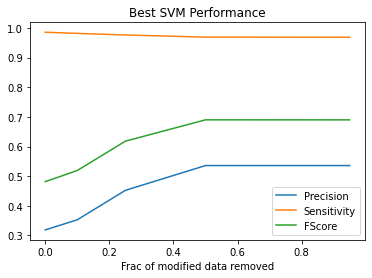

In [23]:
import matplotlib.pyplot as plt

plt.plot(
    [fracs[0], fracs[3], fracs[6], fracs[9], fracs[12], ],
    [precision[0], precision[3], precision[6], precision[9], precision[12], ],
)

plt.plot(
    [fracs[0], fracs[3], fracs[6], fracs[9], fracs[12], ],
    [sensitivity[0], sensitivity[3], sensitivity[6], sensitivity[9], sensitivity[12], ],
)

plt.plot(
    [fracs[0], fracs[3], fracs[6], fracs[9], fracs[12], ],
    [Fscore[0], Fscore[3], Fscore[6], Fscore[9], Fscore[12], ],
)
plt.legend(['Precision', 'Sensitivity', 'FScore'])
plt.xlabel('Frac of modified data removed')
plt.title('Best SVM Performance')

Text(0.5, 1.0, 'Best NN Performance')

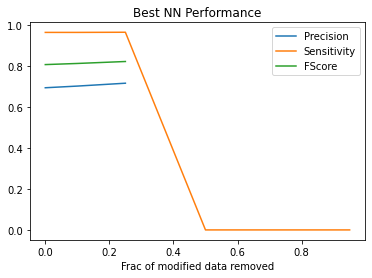

In [26]:
import matplotlib.pyplot as plt

plt.plot(
    [fracs[1], fracs[4], fracs[7], fracs[10], fracs[13], ],
    [precision[1], precision[4], precision[7], precision[10], precision[13], ],
)


plt.plot(
    [fracs[1], fracs[4], fracs[7], fracs[10], fracs[13], ],
    [sensitivity[1], sensitivity[4], sensitivity[7], sensitivity[10], sensitivity[13], ],
)

plt.plot(
    [fracs[1], fracs[4], fracs[7], fracs[10], fracs[13], ],
    [Fscore[1], Fscore[4], Fscore[7], Fscore[10], Fscore[13], ],
)
plt.legend(['Precision', 'Sensitivity', 'FScore'])
plt.xlabel('Frac of modified data removed')
plt.title('Best NN Performance')

Text(0.5, 1.0, 'Best LG Performance')

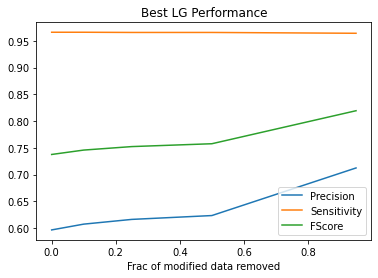

In [28]:
import matplotlib.pyplot as plt

plt.plot(
    [fracs[2], fracs[5], fracs[8], fracs[11], fracs[14], ],
    [precision[2], precision[5], precision[8], precision[11], precision[14], ],
)

plt.plot(
    [fracs[2], fracs[5], fracs[8], fracs[11], fracs[14], ],
    [sensitivity[2], sensitivity[5], sensitivity[8], sensitivity[11], sensitivity[14], ],
)

plt.plot(
    [fracs[2], fracs[5], fracs[8], fracs[11], fracs[14], ],
    [Fscore[2], Fscore[5], Fscore[8], Fscore[11], Fscore[14], ],
)
plt.legend(['Precision', 'Sensitivity', 'FScore'])
plt.xlabel('Frac of modified data removed')
plt.title('Best LG Performance')